# **TRAINING**

In [20]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pprint

# Label Encoding категориальных признаков

df_model_ready = df_merged_final.copy()
label_encoder = LabelEncoder()

for col in final_categorical_features:
    df_model_ready[col] = label_encoder.fit_transform(df_model_ready[col])

Y = df_model_ready['is_fraud']

X = df_model_ready.drop(
    columns=['is_fraud', 'user_id', 'docno', 'transdate', 'timestamp'],
    errors='ignore'
)

X = X.fillna(0)

In [21]:
# Разделение данных (Train, Val, Test)
random_state = 55

# Train (80%) и (Test + Val) (20%)
x_train, x_test_val, y_train, y_test_val = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=random_state,
    stratify=Y
)

# Val (10%) и Test (10%)
x_val, x_test, y_val, y_test = train_test_split(
    x_test_val, y_test_val,
    test_size=0.5,
    random_state=random_state,
    stratify=y_test_val
)

print(f"Размер обучающей выборки (оригинальный): {len(x_train)}")
print(f"Количество мошенничества в Train: {y_train.sum()} (Доля: {y_train.mean():.4f})")


# расчет соотношения: Количество_Класса_0 / Количество_Класса_1
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

Размер обучающей выборки (оригинальный): 10490
Количество мошенничества в Train: 132 (Доля: 0.0126)


# **GRID SEARCH**

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.1],
    'gamma': [0, 0.5, 1],
    'subsample': [0.7, 0.9],
    'n_estimators': [100, 150]
}

In [ ]:
print(param_grid)

{'max_depth': [3, 5, 7], 'learning_rate': [0.03, 0.05, 0.1], 'gamma': [0, 0.5, 1], 'subsample': [0.7, 0.9], 'n_estimators': [100, 150]}


In [ ]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight_value,
    random_state=random_state,
    tree_method="hist",
    eval_metric='aucpr',
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC AUC на CV: {grid_search.best_score_:.4f}")

best_xgb_model = grid_search.best_estimator_


--- 🧠 Запуск Grid Search (Исчерпывающий поиск по сетке) ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
best_xgb_model.fit(x_train, y_train)

def evaluate(trainedmodel, x, y):
    y_pred = trainedmodel.predict(x)
    f1 = f1_score(y, y_pred)
    report = classification_report(y, y_pred)
    acc = accuracy_score(y, y_pred)

    y_pred_proba = trainedmodel.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)

    eval_metrics = {
        'f1_score': f1,
        'accuracy': acc,
        'roc_auc_score': roc_auc
    }
    return eval_metrics, report

pprint._sorted = lambda x:x

eval_train, report_train = evaluate(best_xgb_model, x_train, y_train)
eval_val, report_val = evaluate(best_xgb_model, x_val, y_val)

print('Train Set')
pprint.pprint(eval_train)
print('\n', report_train)

print('Validation Set')
pprint.pprint(eval_val)
print('\n', report_val)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:10:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Set
{'accuracy': 0.999904671115348,
 'f1_score': 0.9962264150943396,
 'roc_auc_score': np.float64(1.0)}

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10358
           1       0.99      1.00      1.00       132

    accuracy                           1.00     10490
   macro avg       1.00      1.00      1.00     10490
weighted avg       1.00      1.00      1.00     10490

Validation Set
{'accuracy': 0.9893211289092296,
 'f1_score': 0.5882352941176471,
 'roc_auc_score': np.float64(0.9181467181467181)}

               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1295
           1       0.56      0.62      0.59        16

    accuracy                           0.99      1311
   macro avg       0.78      0.81      0.79      1311
weighted avg       0.99      0.99      0.99      1311



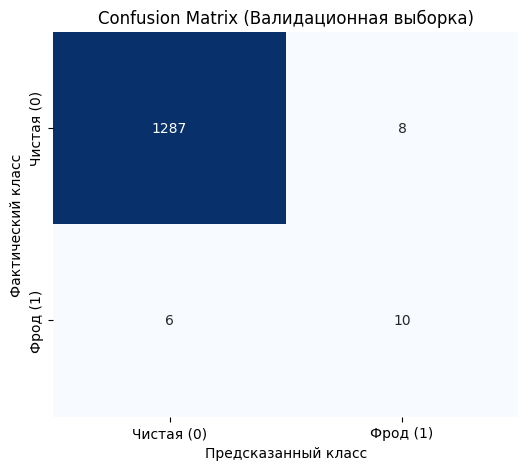

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_val_pred = best_xgb_model.predict(x_val)

cm = confusion_matrix(y_val, y_val_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title('Confusion Matrix (Валидационная выборка)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

# **Previous model without search**

In [ ]:
model_weighted = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    colsample_bytree=0.7,
    scale_pos_weight=scale_pos_weight_value,
    random_state=random_state,
    tree_method="hist",
    eval_metric='aucpr'
)

# grid search

model_weighted.fit(x_train, y_train)

def evaluate(trainedmodel, x, y):
    y_pred = trainedmodel.predict(x)
    f1 = f1_score(y, y_pred)
    report = classification_report(y, y_pred)
    acc = accuracy_score(y, y_pred)

    y_pred_proba = trainedmodel.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)

    eval_metrics = {
        'f1_score': f1,
        'accuracy': acc,
        'roc_auc_score': roc_auc
    }
    return eval_metrics, report

pprint._sorted = lambda x:x

eval_train, report_train = evaluate(model_weighted, x_train, y_train)
eval_val, report_val = evaluate(model_weighted, x_val, y_val)

print('Train Set')
pprint.pprint(eval_train)
print('\n', report_train)

print('Validation Set')
pprint.pprint(eval_val)
print('\n', report_val)

Train Set
{'accuracy': 0.9627264061010486,
 'f1_score': 0.4030534351145038,
 'roc_auc_score': np.float64(0.998390206369546)}

               precision    recall  f1-score   support

           0       1.00      0.96      0.98     10358
           1       0.25      1.00      0.40       132

    accuracy                           0.96     10490
   macro avg       0.63      0.98      0.69     10490
weighted avg       0.99      0.96      0.97     10490

Validation Set
{'accuracy': 0.9427917620137299,
 'f1_score': 0.24242424242424243,
 'roc_auc_score': np.float64(0.906949806949807)}

               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1295
           1       0.14      0.75      0.24        16

    accuracy                           0.94      1311
   macro avg       0.57      0.85      0.61      1311
weighted avg       0.99      0.94      0.96      1311



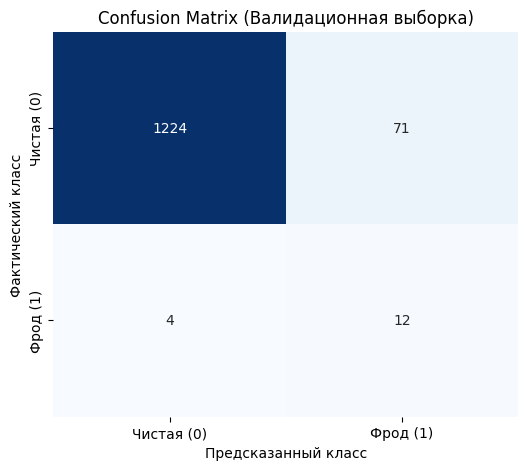

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_val_pred = model_weighted.predict(x_val)

cm = confusion_matrix(y_val, y_val_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title('Confusion Matrix (Валидационная выборка)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()



{'accuracy': 0.9611280487804879,
 'f1_score': 0.3855421686746988,
 'roc_auc_score': np.float64(0.9916874858051329)}

               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1295
           1       0.24      0.94      0.39        17

    accuracy                           0.96      1312
   macro avg       0.62      0.95      0.68      1312
weighted avg       0.99      0.96      0.97      1312



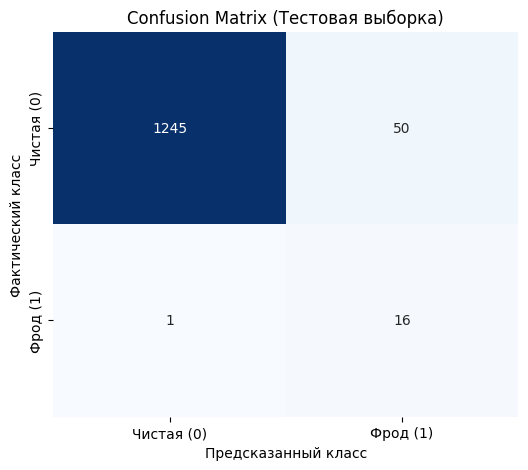

In [ ]:
# test
eval_test, report_test = evaluate(model_weighted, x_test, y_test)

pprint.pprint(eval_test)
print('\n', report_test)

y_test_pred = model_weighted.predict(x_test)

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title('Confusion Matrix (Тестовая выборка)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

In [ ]:
# сохранить модель
import joblib

drive_path = '/content/gdrive/My Drive/Hackaton/XGBoost_weighted_model.joblib'

joblib.dump(model_weighted, drive_path)

['/content/gdrive/My Drive/Hackaton/XGBoost_weighted_model.joblib']

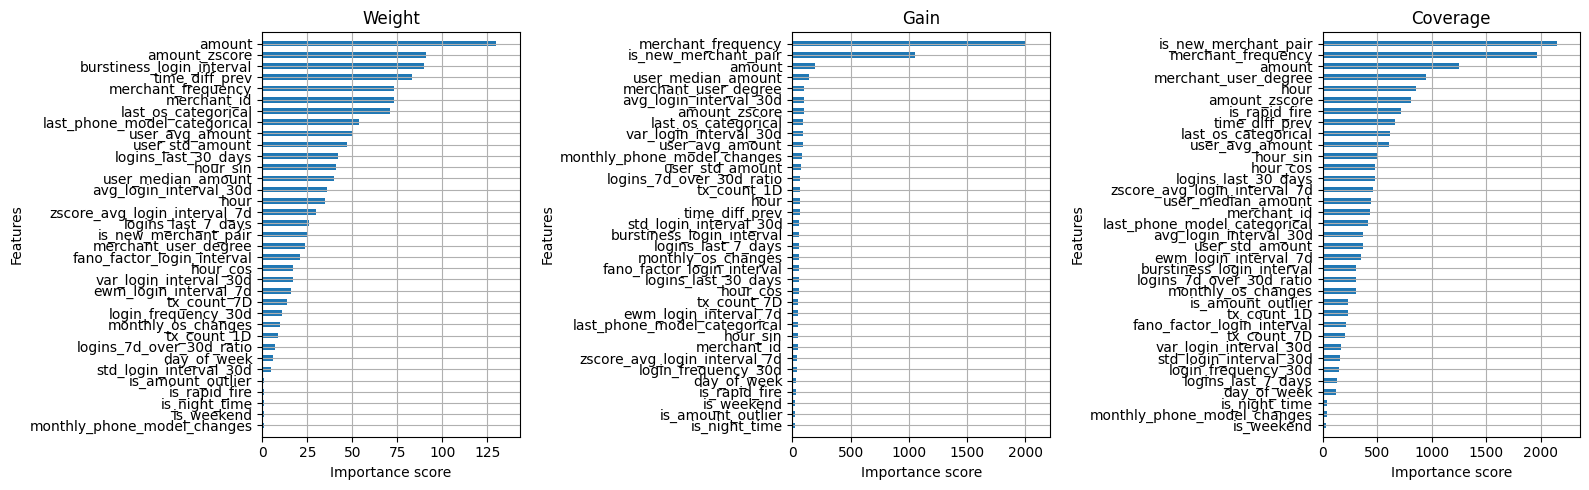

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1, 3, figsize=(16,5))

plot_importance(booster=model_weighted, importance_type='weight', title='Weight', show_values=False, height=0.5, ax = ax[0])

# plot importances with split mean gain
plot_importance(booster=model_weighted, importance_type='gain', title='Gain', show_values=False, height=0.5, ax = ax[1])

# plot importances with sample coverage
plot_importance( booster=model_weighted, importance_type='cover', title='Coverage', show_values=False, height=0.5, ax = ax[2])

plt.tight_layout()
plt.show()

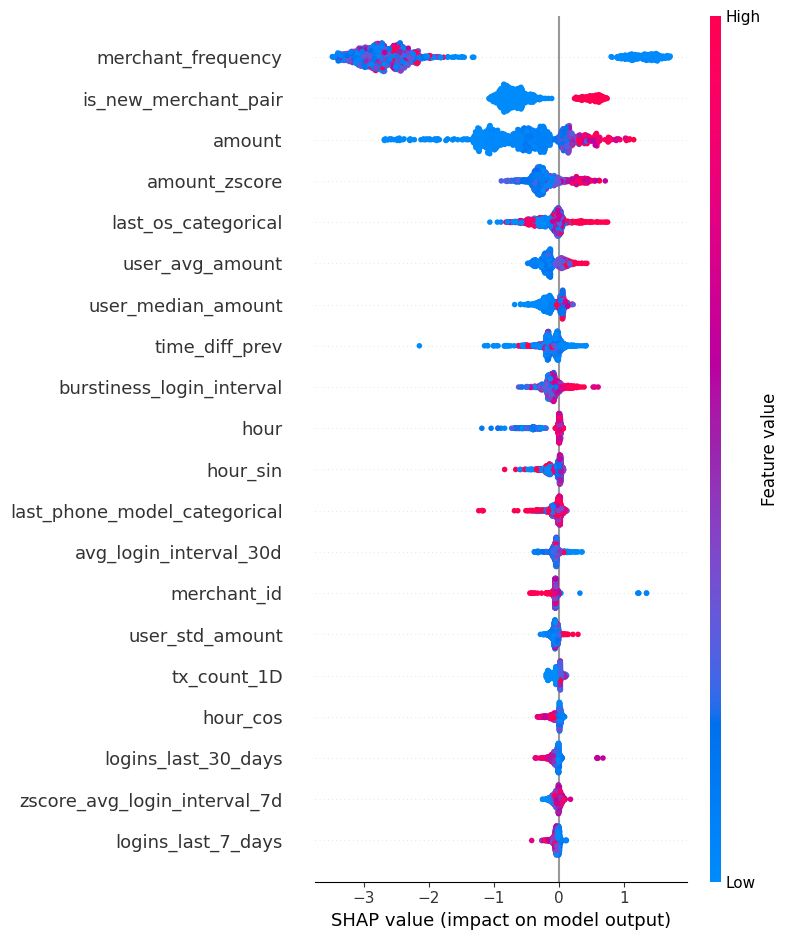

In [ ]:
import shap

x_test_sample_df = x_test.sample(1000, random_state=42)

explainer = shap.TreeExplainer(model_weighted)

shap_values = explainer.shap_values(x_test_sample_df)

if len(shap_values.shape) == 2:
    shap_values_matrix = shap_values
else:
    shap_values_matrix = shap_values[1]

shap.summary_plot(
    shap_values_matrix,
    x_test_sample_df,
    feature_names=x_test_sample_df.columns
)

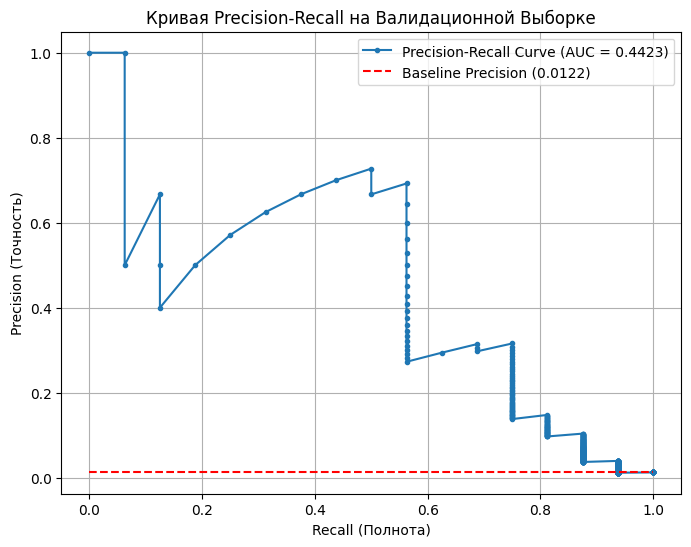


Точка максимального F1-score (0.6207):
  Порог: 0.9490
  Precision: 0.6923
  Recall: 0.5625


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

y_proba_val = model_weighted.predict_proba(x_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_proba_val)

pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')

baseline_precision = y_val.sum() / len(y_val)
plt.plot([0, 1], [baseline_precision, baseline_precision], linestyle='--', color='red', label=f'Baseline Precision ({baseline_precision:.4f})')

plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Кривая Precision-Recall на Валидационной Выборке')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Вывод ключевых точек (для справки) ---
# Находим F1-score для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_index = np.argmax(f1_scores)

print(f"\nТочка максимального F1-score ({f1_scores[best_f1_index]:.4f}):")
print(f"  Порог: {thresholds[best_f1_index]:.4f}")
print(f"  Precision: {precision[best_f1_index]:.4f}")
print(f"  Recall: {recall[best_f1_index]:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_proba_test = model_weighted.predict_proba(x_test)[:, 1]

NEW_THRESHOLD = 0.7

y_pred_new_threshold = np.where(y_proba_test >= NEW_THRESHOLD, 1, 0)

# Оценка метрик с новым порогом
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1295
           1       0.35      0.94      0.51        17

    accuracy                           0.98      1312
   macro avg       0.67      0.96      0.75      1312
weighted avg       0.99      0.98      0.98      1312



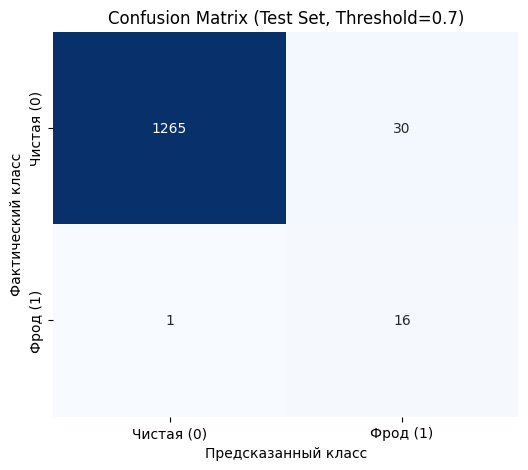

In [ ]:
cm_optimized = confusion_matrix(y_test, y_pred_new_threshold)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_optimized,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title(f'Confusion Matrix (Test Set, Threshold={NEW_THRESHOLD})')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

# **LGBM**

In [26]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

param_grid_lgbm = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.1],
    'reg_alpha': [0, 0.1, 0.5],
    'feature_fraction': [0.7, 0.9],
}

In [27]:
lgbm_model = LGBMClassifier(
    random_state=random_state,
    metric='aucpr',
    n_estimators=150,
    n_jobs=-1,
    verbose=-1,
    scale_pos_weight = scale_pos_weight_value
)

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_lgbm.fit(x_train, y_train)
print(f"Лучшие параметры LGBM: {grid_search_lgbm.best_params_}")
print(f"Лучший ROC AUC на CV (LGBM): {grid_search_lgbm.best_score_:.4f}")

best_lgbm_model = grid_search_lgbm.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры LGBM: {'feature_fraction': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 63, 'reg_alpha': 0}
Лучший ROC AUC на CV (LGBM): 0.9826


In [33]:
import pprint

best_lgbm_model.fit(x_train, y_train)
def evaluate(trainedmodel, x, y):
    '''
    Оценивает производительность модели и возвращает метрики и отчет.
    '''
    # 1. Бинарное предсказание (использует порог 0.5)
    y_pred = trainedmodel.predict(x)

    # 2. Расчет ключевых метрик
    f1 = f1_score(y, y_pred)
    report = classification_report(y, y_pred)
    acc = accuracy_score(y, y_pred)

    # 3. Вероятностное предсказание для ROC AUC
    y_pred_proba = trainedmodel.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)

    eval_metrics = {
        'f1_score': f1,
        'accuracy': acc,
        'roc_auc_score': roc_auc
    }
    return eval_metrics, report

pprint._sorted = lambda x:x

# --- Оценка на Обучающем Наборе (x_train, y_train) ---
eval_train, report_train = evaluate(best_lgbm_model, x_train, y_train)
print('\n--- 📊 Оценка производительности (Train Set) ---')
pprint.pprint(eval_train)
print('\n', report_train)

# --- Оценка на Валидационном Наборе (x_val, y_val) ---
eval_val, report_val = evaluate(best_lgbm_model, x_val, y_val)
print('\n--- 🚀 Оценка производительности (Validation Set) ---')
pprint.pprint(eval_val)
print('\n', report_val)


--- 📊 Оценка производительности (Train Set) ---
{'accuracy': 1.0,
 'f1_score': 1.0,
 'roc_auc_score': np.float64(0.9999999999999999)}

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10358
           1       1.00      1.00      1.00       132

    accuracy                           1.00     10490
   macro avg       1.00      1.00      1.00     10490
weighted avg       1.00      1.00      1.00     10490


--- 🚀 Оценка производительности (Validation Set) ---
{'accuracy': 0.9908466819221968,
 'f1_score': 0.625,
 'roc_auc_score': np.float64(0.9231660231660233)}

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1295
           1       0.62      0.62      0.62        16

    accuracy                           0.99      1311
   macro avg       0.81      0.81      0.81      1311
weighted avg       0.99      0.99      0.99      1311



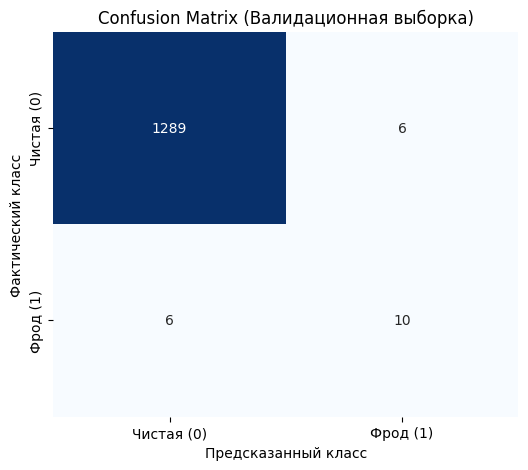

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_val_pred = best_lgbm_model.predict(x_val)

cm = confusion_matrix(y_val, y_val_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title('Confusion Matrix (Валидационная выборка)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()